# BBM406 - Fundamentals of Machine Learning Course Project 


### This file contains Neural Network Application of Predicting Origin of Music 





In [2]:
!pip install eli5
!pip install gmplot

     |████████████████████████████████| 112kB 7.2MB/s 
     |████████████████████████████████| 174kB 7.8MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, accuracy_score, f1_score, r2_score

from geopy.distance import great_circle, vincenty, geodesic
from geopy.geocoders import Nominatim
import eli5
from eli5.sklearn import PermutationImportance

import gmplot
import plotly.express as px

from warnings import filterwarnings
filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
df = pd.read_csv("database.txt", delimiter=",", header=None)

# change last 2 column name as a latitude and longitude 
column_names = ["Feature " + str(x) for x in range(68)]
column_names.append('latitude')
column_names.append('longitude')
df.columns = column_names

print(df.head())

   Feature 0  Feature 1  Feature 2  ...  Feature 67  latitude  longitude
0   7.161286   7.835325   2.911583  ...   -0.836250    -15.75     -47.95
1   0.225763  -0.094169  -0.603646  ...    1.391141     14.91     -23.51
2  -0.692525  -0.517801  -0.788035  ...    1.063847     12.65      -8.00
3  -0.735562  -0.684055   2.058215  ...   -0.392197      9.03      38.74
4   0.570272   0.273157  -0.279214  ...    1.289783     34.03      -6.85

[5 rows x 70 columns]


In [8]:
# data preparation part 
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)   
print(df.info()) 
print(np.any(np.isnan(df.values)))
print(np.all(np.isfinite(df.values)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059 entries, 0 to 1058
Data columns (total 70 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Feature 0   1059 non-null   float64
 1   Feature 1   1059 non-null   float64
 2   Feature 2   1059 non-null   float64
 3   Feature 3   1059 non-null   float64
 4   Feature 4   1059 non-null   float64
 5   Feature 5   1059 non-null   float64
 6   Feature 6   1059 non-null   float64
 7   Feature 7   1059 non-null   float64
 8   Feature 8   1059 non-null   float64
 9   Feature 9   1059 non-null   float64
 10  Feature 10  1059 non-null   float64
 11  Feature 11  1059 non-null   float64
 12  Feature 12  1059 non-null   float64
 13  Feature 13  1059 non-null   float64
 14  Feature 14  1059 non-null   float64
 15  Feature 15  1059 non-null   float64
 16  Feature 16  1059 non-null   float64
 17  Feature 17  1059 non-null   float64
 18  Feature 18  1059 non-null   float64
 19  Feature 19  1059 non-null  

In [11]:
# make sure all values are proper 

_assert_all_finite(df.values)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(1, inplace=True)

In [12]:
# split features columns and target labels
X = df.iloc[:,:-2]
y = df.iloc[:,-2:]
print(X)
print(y)

      Feature 0  Feature 1  Feature 2  ...  Feature 65  Feature 66  Feature 67
0      7.161286   7.835325   2.911583  ...   -0.668840   -0.914772   -0.836250
1      0.225763  -0.094169  -0.603646  ...    1.088478   -0.123595    1.391141
2     -0.692525  -0.517801  -0.788035  ...    2.081069    1.375763    1.063847
3     -0.735562  -0.684055   2.058215  ...   -0.385005   -0.012326   -0.392197
4      0.570272   0.273157  -0.279214  ...    0.119658    0.271838    1.289783
...         ...        ...        ...  ...         ...         ...         ...
1054   0.399577   0.310805  -0.039326  ...    2.467278    1.867699    1.719302
1055   1.640386   1.306224   0.192745  ...    1.126762    2.220671    4.422651
1056  -0.772360  -0.670596  -0.840420  ...   -0.718175   -0.983640   -0.573822
1057  -0.996965  -1.099395   3.515274  ...   -0.137473   -0.781036   -0.832167
1058  -0.150911  -0.094333  -0.568885  ...    5.244305    2.506568    1.462580

[1059 rows x 68 columns]
      latitude  longitude


In [15]:
# train test split with  test size 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [16]:
# model 
regr = MLPRegressor(random_state=1234, max_iter=4000,hidden_layer_sizes=(12,12),activation='identity',solver='adam',batch_size=64,learning_rate='invscaling',alpha=1000).fit(X_train, y_train)
y_predict = regr.predict(X_test)

In [18]:
# evaluation using mean squared error and r2_score

# first value is latitude error and second value is longitude error in km (in terms of euclidean distance)
print(mean_squared_error(y_predict, y_test, multioutput='raw_values'))

# regression score function 
print(r2_score(y_predict,y_test, multioutput='raw_values'))
 

[ 290.24509326 2088.92918618]
[-6.51346789 -3.24105706]


In [19]:
# application of haversine formula 
def distance_km(xpred,ypred,x,y): 
  dlon = radians(ypred) - radians(y)
  dlat = radians(xpred) - radians(x)
    
  a = sin(dlat / 2)**2 + cos(x) * cos(xpred) * sin(dlon / 2)**2
  if a<0:
    a *= -1
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  return 6373 * c

label_array = y_test[['latitude', 'longitude']].to_numpy()


sum = 0;
for i in range(y_test.shape[0]):
  # world coordinates boundaries
  if y_predict[i][0]>90:
    y_predict[i][0]=90

  if y_predict[i][1]>180:
    y_predict[i][1]=180

  if y_predict[i][0]<-90:
    y_predict[i][0]=-90

  if y_predict[i][1]<-180:
    y_predict[i][1]=-180

  p1 = (y_predict[i][0], y_predict[i][1]) # predicted point
  p2 = (label_array[i][0],label_array[i][1]) # actual point
  sum += distance_km(y_predict[i][0], y_predict[i][1],label_array[i][0],label_array[i][1])

# mean error in km (in terms of great circle distance)
print(sum/y_test.shape[0])

2714.990000516712


In [20]:
# show distances between two points using GoogleMapPlotter

latitude_list = [ y_test.values[18][0], y_predict[18][0] ]
longitude_list = [y_test.values[18][1], y_predict[18][1] ]

gmap = gmplot.GoogleMapPlotter(min(latitude_list),
                                max(longitude_list), 13)
  
# marker method of map object 
gmap.marker(y_test.values[18][0], y_test.values[18][1], color='cornflowerblue')
gmap.marker(y_predict[18][0], y_predict[18][1], color='cornflowerblue')

# scatter points on the google map
gmap.scatter( latitude_list, longitude_list, '# FF0000',
                              size = 40, marker = False )
  
# Plot method Draw a line in
# between given coordinates
gmap.plot(latitude_list, longitude_list, 
           'red', edge_width = 2.5)
  

gmap.draw( "map.html" )

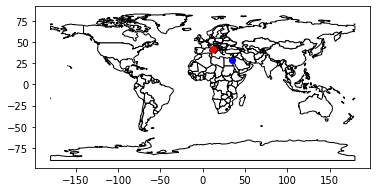

In [ ]:
# show predicted and actual points using geopandas 

test_lat = [y_test.values[0][0] ]
test_long = [y_test.values[0][1] ]
pred_lat = [y_predict[0][0] ]
pred_long = [y_predict[0][1] ]


test_df = pd.DataFrame({'latitude' : test_lat,'longitude' : test_long})
pred_df = pd.DataFrame({'latitude' : pred_lat,'longitude' : pred_long})

test_gdf = geopandas.GeoDataFrame(test_df, geometry=geopandas.points_from_xy(test_df.longitude, test_df.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
test_gdf.plot(ax=ax, color='red')

pred_gdf = geopandas.GeoDataFrame(pred_df, geometry=geopandas.points_from_xy(pred_df.longitude, pred_df.latitude))
pred_gdf.plot(ax=ax,color='blue')
plt.show()